분석 주제 :  Porto Seguro 자동차 회사의 안전 운전자 예측

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import *
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', 100)

1. raw 데이터 특성  
ind = individual (개인)  
reg = registration (등록)  
car = car  
calc = calculated field (계산된 필드)  
bin = binary features (이진 피처) cat = categorical features (범주형 피처)  
!bin && !cat = continuous values of integers (연속된 정수)  
missing value = -1로 표기  
target col = 피보험자에 대한 청구 접수 (0 or 1)  

In [52]:
trainset = pd.read_csv('../porto_seguro/train.csv')
testset = pd.read_csv('../porto_seguro/test.csv')

In [5]:
trainset.head()

id  target  ps_ind_01  ps_ind_02_cat  ps_ind_03  ps_ind_04_cat  \
0   7       0          2              2          5              1   
1   9       0          1              1          7              0   
2  13       0          5              4          9              1   
3  16       0          0              1          2              0   
4  17       0          0              2          0              1   

   ps_ind_05_cat  ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin  ps_ind_09_bin  \
0              0              0              1              0              0   
1              0              0              0              1              0   
2              0              0              0              1              0   
3              0              1              0              0              0   
4              0              1              0              0              0   

   ps_ind_10_bin  ps_ind_11_bin  ps_ind_12_bin  ps_ind_13_bin  ps_ind_14  \
0              0              0              0              0          0   
1              0              0              0              0          0   
2              0              0              0              0          0   
3              0              0              0              0          0   
4              0              0              0              0          0   

   ps_ind_15  ps_ind_16_bin  ps_ind_17_bin  ps_ind_18_bin  ps_reg_01  \
0         11              0              1              0        0.7   
1          3              0              0              1        0.8   
2         12              1              0              0        0.0   
3          8              1              0              0        0.9   
4          9              1              0              0        0.7   

   ps_reg_02  ps_reg_03  ps_car_01_cat  ps_car_02_cat  ps_car_03_cat  \
0        0.2   0.718070             10              1             -1   
1        0.4   0.766078             11              1             -1   
2        0.0  -1.000000              7              1             -1   
3        0.2   0.580948              7              1              0   
4        0.6   0.840759             11              1             -1   

   ps_car_04_cat  ps_car_05_cat  ps_car_06_cat  ps_car_07_cat  ps_car_08_cat  \
0              0              1              4              1              0   
1              0             -1             11              1              1   
2              0             -1             14              1              1   
3              0              1             11              1              1   
4              0             -1             14              1              1   

   ps_car_09_cat  ps_car_10_cat  ps_car_11_cat  ps_car_11  ps_car_12  \
0              0              1             12          2   0.400000   
1              2              1             19          3   0.316228   
2              2              1             60          1   0.316228   
3              3              1            104          1   0.374166   
4              2              1             82          3   0.316070   

   ps_car_13  ps_car_14  ps_car_15  ps_calc_01  ps_calc_02  ps_calc_03  \
0   0.883679   0.370810   3.605551         0.6         0.5         0.2   
1   0.618817   0.388716   2.449490         0.3         0.1         0.3   
2   0.641586   0.347275   3.316625         0.5         0.7         0.1   
3   0.542949   0.294958   2.000000         0.6         0.9         0.1   
4   0.565832   0.365103   2.000000         0.4         0.6         0.0   

   ps_calc_04  ps_calc_05  ps_calc_06  ps_calc_07  ps_calc_08  ps_calc_09  \
0           3           1          10           1          10           1   
1           2           1           9           5           8           1   
2           2           2           9           1           8           2   
3           2           4           7           1           8           4   
4           2           2           6   

In [7]:
print (
    " 훈련용 데이터 셋 row, col =", trainset.shape,
    "\n 테스트 데이터 셋 row, col =", testset.shape,
    "\n 두 데이터 세트 간의 차이 = ", set(trainset.columns) - set(testset.columns)
      )

 훈련용 데이터 셋 row, col = (595212, 59) 
 테스트 데이터 셋 row, col = (892816, 58) 
 두 데이터 세트 간의 차이 =  {'target'}


## 2-2 메타데이터 정제

In [53]:
data = []
for feature in trainset.columns:
    # 타겟,id,input으로 구분
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'
        
    # print(feature)
         
    # binary, categorical , real ,integer 로 구분
    if 'bin' in feature or feature == 'target':
        type = 'binary'
    elif 'cat' in feature or feature == 'id':
        type = 'categorical'
    elif trainset[feature].dtype == float or isinstance(trainset[feature].dtype, float):
        type = 'real'
    elif trainset[feature].dtype == int:
        type = 'integer'
        
    # id 값과 preserve 로 구분
    preserve = True
    if feature == 'id':
        preserve = False
    
    # dtype 
    dtype = trainset[feature].dtype
    
    category = 'none'
    # 범주형 변수 정의 
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'
    
    
    # 딕셔너리 형태로 저장
    feature_dictionary = {
        'varname': feature,
        'use': use,
        'type': type,
        'preserve': preserve,
        'dtype': dtype,
        'category' : category
    }
    data.append(feature_dictionary)
    
metadata = pd.DataFrame(data, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace=True)
metadata

use         type  preserve    dtype      category
varname                                                             
id                  id  categorical     False    int64          none
target          target       binary      True    int64          none
ps_ind_01        input       binary      True    int64    individual
ps_ind_02_cat    input  categorical      True    int64    individual
ps_ind_03        input  categorical      True    int64    individual
ps_ind_04_cat    input  categorical      True    int64    individual
ps_ind_05_cat    input  categorical      True    int64    individual
ps_ind_06_bin    input       binary      True    int64    individual
ps_ind_07_bin    input       binary      True    int64    individual
ps_ind_08_bin    input       binary      True    int64    individual
ps_ind_09_bin    input       binary      True    int64    individual
ps_ind_10_bin    input       binary      True    int64    individual
ps_ind_11_bin    input       binary      True    int64    individual
ps_ind_12_bin    input       binary      True    int64    individual
ps_ind_13_bin    input       binary      True    int64    individual
ps_ind_14        input       binary      True    int64    individual
ps_ind_15        input       binary      True    int64    individual
ps_ind_16_bin    input       binary      True    int64    individual
ps_ind_17_bin    input       binary      True    int64    individual
ps_ind_18_bin    input       binary      True    int64    individual
ps_reg_01        input         real      True  float64  registration
ps_reg_02        input         real      True  float64  registration
ps_reg_03        input         real      True  float64  registration
ps_car_01_cat    input  categorical      True    int64           car
ps_car_02_cat    input  categorical      True    int64           car
ps_car_03_cat    input  categorical      True    int64           car
ps_car_04_cat    input  categorical      True    int64           car
ps_car_05_cat    input  categorical      True    int64           car
ps_car_06_cat    input  categorical      True    int64           car
ps_car_07_cat    input  categorical      True    int64           car
ps_car_08_cat    input  categorical      True    int64           car
ps_car_09_cat    input  categorical      True    int64           car
ps_car_10_cat    input  categorical      True    int64           car
ps_car_11_cat    input  categorical      True    int64           car
ps_car_11        input  categorical      True    int64           car
ps_car_12        input         real      True  float64           car
ps_car_13        input         real      True  float64           car
ps_car_14        input         real      True  float64           car
ps_car_15        input         real      True  float64           car
ps_calc_01       input         real      True  float64    calculated
ps_calc_02       input         real      True  float64    calculated
ps_calc_03       input         real      True  float64    calculated
ps_calc_04       input         real      True    int64    calculated
ps_calc_05       input         real      True    int64    calculated
ps_calc_06       input         real      True    int64    calculated
ps_calc_07       input         real      True    int64    calculated
ps_calc_08       input         real      True    int64    calculated
ps_calc_09       input         real      True    int64    calculated
ps_calc_10       input         real      True    int64    calculated
ps_calc_11       input         real      True    int64    calculated
ps_calc_12       input         real      True    int64    calculated
ps_calc_13       input         real      True    int64    calculated
ps_calc_14       input         real      True    int64    calculated
ps_calc_15_bin   input       binary      True    int64    calculated
ps_calc_16_bin   input       binary      True    int64    calculated
ps_calc_17_bin   input       binary      True    int64    calculated
ps_calc_18_bin   

In [16]:
#범주형 변수 종류

metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11'],
      dtype='object', name='varname')

In [17]:
pd.DataFrame({'count' : metadata.groupby(['category'])['category'].size()}).reset_index()

category  count
0    calculated     20
1           car     16
2    individual     18
3          none      2
4  registration      3

## 3.데이터 분석 및 통계 
### feature 특성파악


<Figure size 640x480 with 0 Axes>

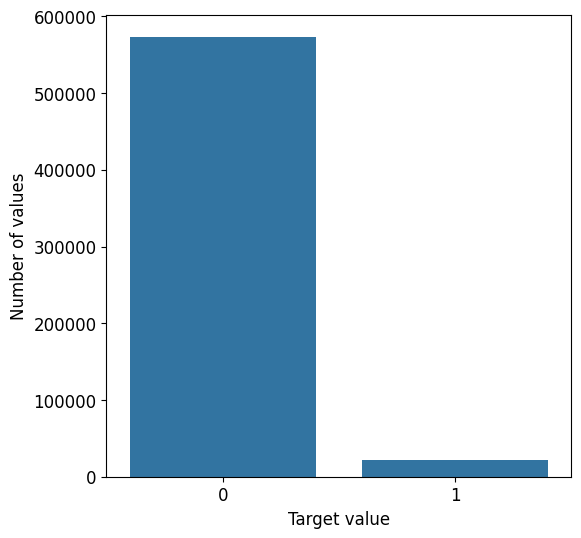

In [21]:
##### 1) 타겟변수

plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
x = trainset['target'].value_counts().index.values
y = trainset["target"].value_counts().values
# Bar plot
# Order the bars descending on target mean
sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

# 0: 청구접수 안한경우, 1: 청구접수한 경우 
# 청구 접수 안한경우가 월등히 많기때문에 언더샘플링을 진행 

# https://blog.naver.com/ansrl23/222921735687
# 언더샘플링 : 데이터를 적게만들어 학습진행
# 오버샘플링 : 데이터를 복제하여 숫자를 뻥튀기함

In [62]:
##### 2) Real Feature

# 메타데이터의 타입이 실수인 (real number) 경우와 preserve인 경우를 동시에 만족하는 variable값의 통계값산출

variable = metadata[(metadata.type == 'real') & (metadata.preserve)].index
# metadata.preserve
trainset[variable].describe()


ps_reg_01      ps_reg_02      ps_reg_03      ps_car_12  \
count  595212.000000  595212.000000  487440.000000  595211.000000   
mean        0.610991       0.439184       0.894047       0.379947   
std         0.287643       0.404264       0.345413       0.058300   
min         0.000000       0.000000       0.061237       0.100000   
25%         0.400000       0.200000       0.633443       0.316228   
50%         0.700000       0.300000       0.801561       0.374166   
75%         0.900000       0.600000       1.083974       0.400000   
max         0.900000       1.800000       4.037945       1.264911   

           ps_car_13      ps_car_14      ps_car_15     ps_calc_01  \
count  595212.000000  552592.000000  595212.000000  595212.000000   
mean        0.813265       0.374691       3.065899       0.449756   
std         0.224588       0.045610       0.731366       0.287198   
min         0.250619       0.109545       0.000000       0.000000   
25%         0.670867       0.350428       2.828427       0.200000   
50%         0.765811       0.373497       3.316625       0.500000   
75%         0.906190       0.398121       3.605551       0.700000   
max         3.720626       0.636396       3.741657       0.900000   

          ps_calc_02     ps_calc_03     ps_calc_04     ps_calc_05  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean        0.449589       0.449849       2.372081       1.885886   
std         0.286893       0.287153       1.117219       1.134927   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.200000       0.200000       2.000000       1.000000   
50%         0.400000       0.500000       2.000000       2.000000   
75%         0.700000       0.700000       3.000000       3.000000   
max         0.900000       0.900000       5.000000       6.000000   

          ps_calc_06     ps_calc_07     ps_calc_08     ps_calc_09  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean        7.689445       3.005823       9.225904       2.339034   
std         1.334312       1.414564       1.459672       1.246949   
min         0.000000       0.000000       2.000000       0.000000   
25%         7.000000       2.000000       8.000000       1.000000   
50%         8.000000       3.000000       9.000000       2.000000   
75%         9.000000       4.000000      10.000000       3.000000   
max        10.000000       9.000000      12.000000       7.000000   

          ps_calc_10     ps_calc_11     ps_calc_12     ps_calc_13  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean        8.433590       5.441382       1.441918       2.872288   
std         2.904597       2.332871       1.202963       1.694887   
min         0.000000       0.000000       0.000000       0.000000   
25%         6.000000       4.000000       1.000000       2.000000   
50%         8.000000       5.000000       1.000000       3.000000   
75%        10.000000       7.000000       2.000000       4.000000   
max        25.000000      19.000000      10.000000      13.000000   

          ps_calc_14  
count  595212.000000  
mean        7.539026  
std         2.746652  
min         0.000000  
25%         6.000000  
50%         7.000000  
75%         9.000000  
max        23.000000

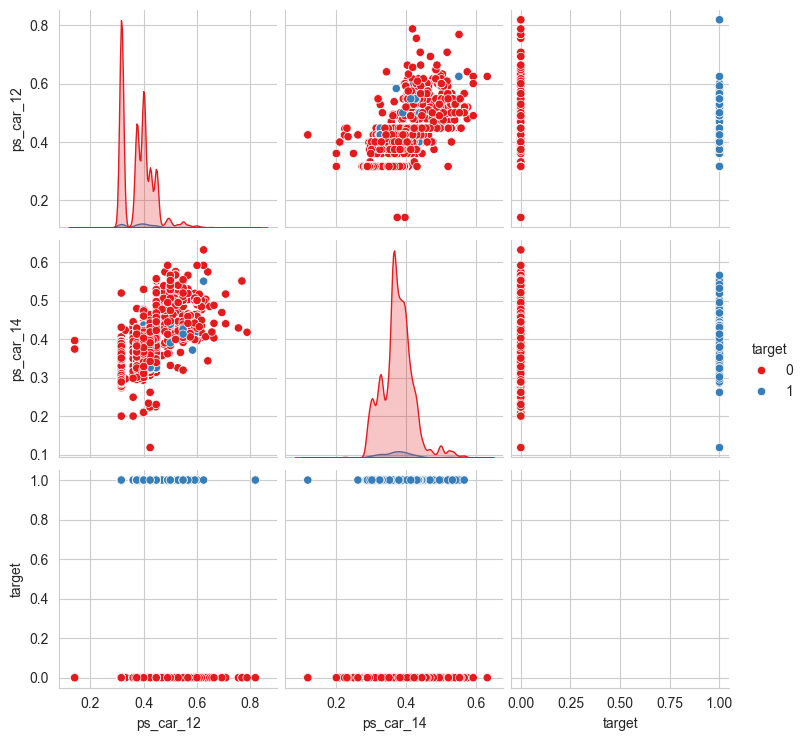

In [64]:
##### 3) 결측값이 있는 ps_car_12, ps_car_14 , target 에 대한 pairplot 비교
sample = trainset.sample(frac=0.05)
var = ['ps_car_12', 'ps_car_14', 'target']
sns.pairplot(sample,  hue='target', palette = 'Set1', diag_kind='kde', vars=var)
plt.show()


# pairplot 에 대한 자료
# https://steadiness-193.tistory.com/198

ps_reg_01      0.900000
ps_reg_02      1.800000
ps_reg_03      4.037945
ps_car_12      1.264911
ps_car_13      3.720626
ps_car_14      0.636396
ps_car_15      3.741657
ps_calc_01     0.900000
ps_calc_02     0.900000
ps_calc_03     0.900000
ps_calc_04     5.000000
ps_calc_05     6.000000
ps_calc_06    10.000000
ps_calc_07     9.000000
ps_calc_08    12.000000
ps_calc_09     7.000000
ps_calc_10    25.000000
ps_calc_11    19.000000
ps_calc_12    10.000000
ps_calc_13    13.000000
ps_calc_14    23.000000
dtype: float64


<Figure size 640x480 with 0 Axes>

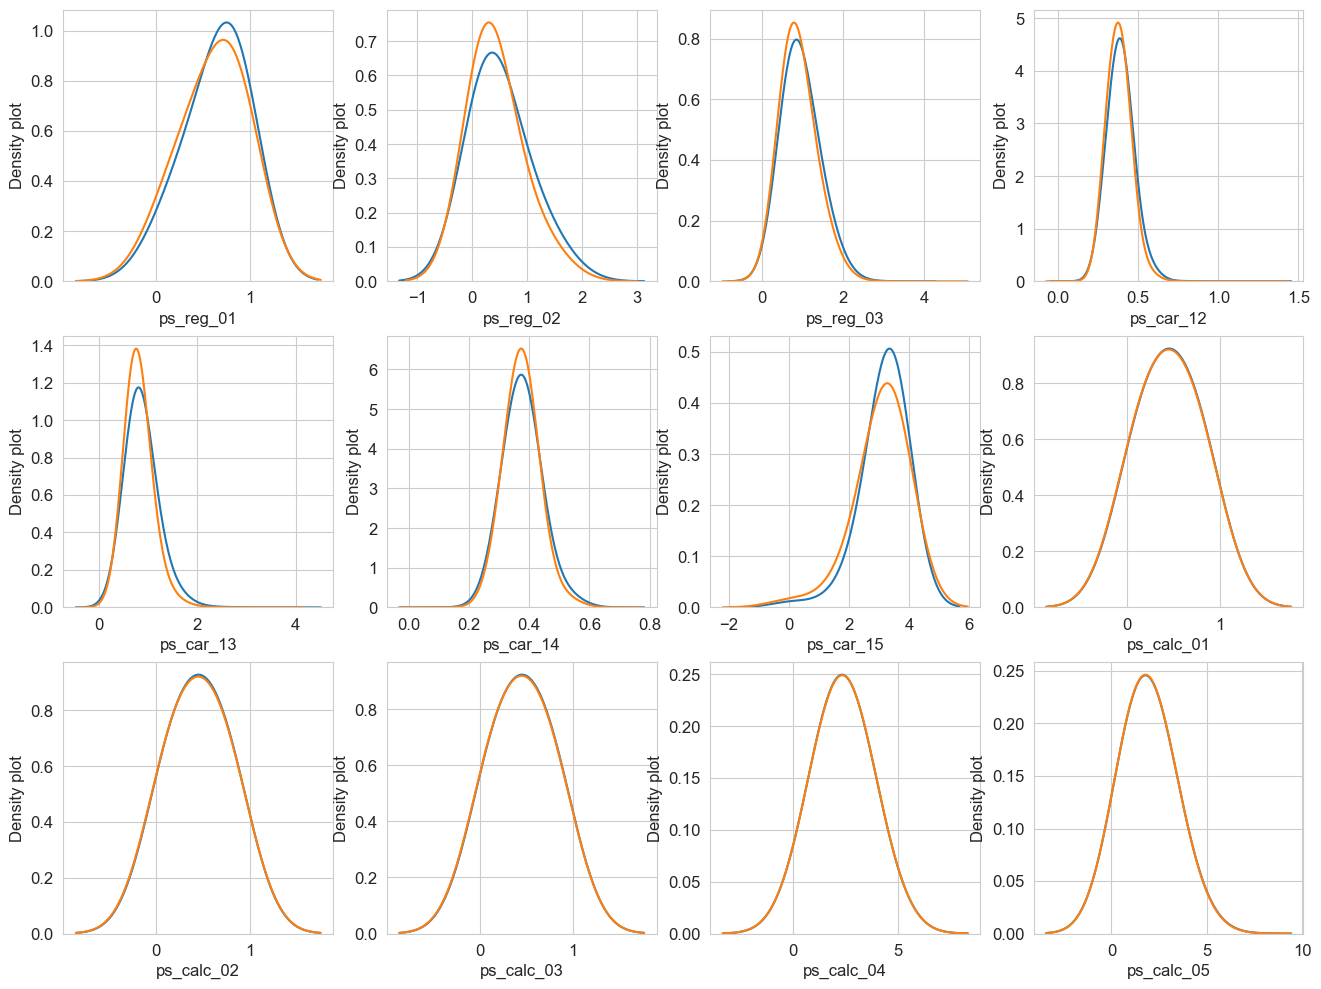

In [119]:
##### 4) Calculated features


# 아래 그래프에서 'ps_calc_01', 'ps_calc_02', 'ps_calc_03' 의 경우 최대값이 0.9로 가장 유사한 분포를 가진다.
# kdeplot 에대한 설명 https://seaborn.pydata.org/generated/seaborn.kdeplot.html
# 커널 대역폭 https://stats.stackexchange.com/questions/90656/kernel-bandwidth-scotts-vs-silvermans-rules

var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
print(trainset[var].max())
# print(var)
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

# print(t1)
# print(t0)

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3,4,figsize=(16,12))

for feature in var:
    i += 1
    
    # print(feature , i)
    
    plt.subplot(3,4,i)
    sns.kdeplot(t1[feature],bw_method=1, label="target = 1") # bw 대신 bw_method 
    sns.kdeplot(t0[feature],bw_method=1, label="target = 0") 
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
    if i == 12:    # i가 12일 때
        break
plt.show()

# 질문 ps_reg_02, ps_car_13, ps_car_15 가장 다른 분포를 보여주는 이유 ? 

#내생각 ps_reg_01, ps_reg_02, ps_car_15

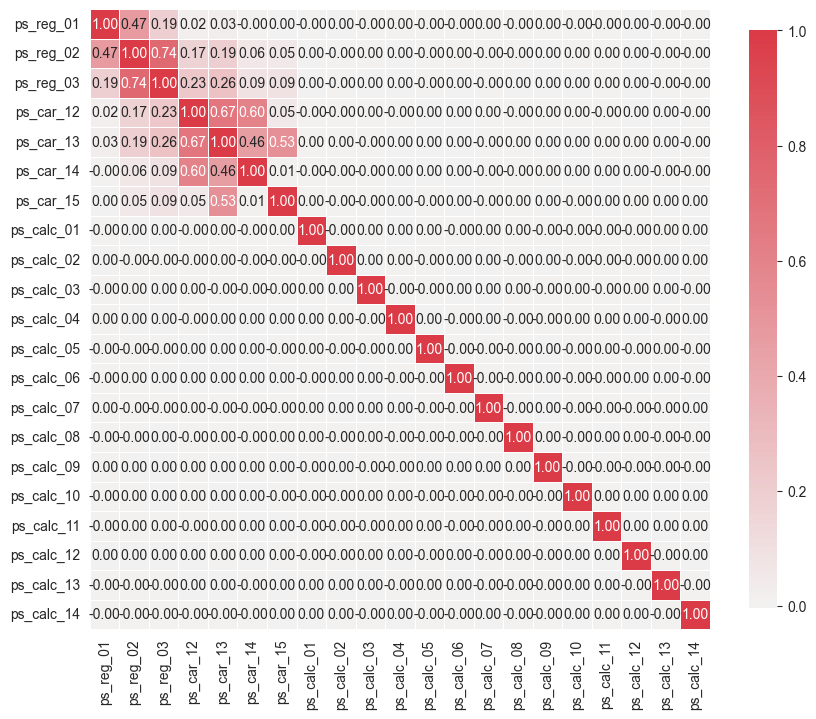

In [90]:
##### 5) 실수(Real feature) 의 상관관계

def corr_heatmap(var):
    correlations = trainset[var].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(50, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show()
    
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
corr_heatmap(var)




### 강한 상관관계의 경우  
ps_reg_01 with ps_reg_02 (0.47)  
ps_reg_02 with ps_reg_03 (0.74)  
ps_car_12 with ps_car_13 (0.67)  
ps_car_12 with ps_car_14 (0.60)  
ps_car_13 with ps_car_15 (0.53)  

해당 경우만 subsampleing 을 진행

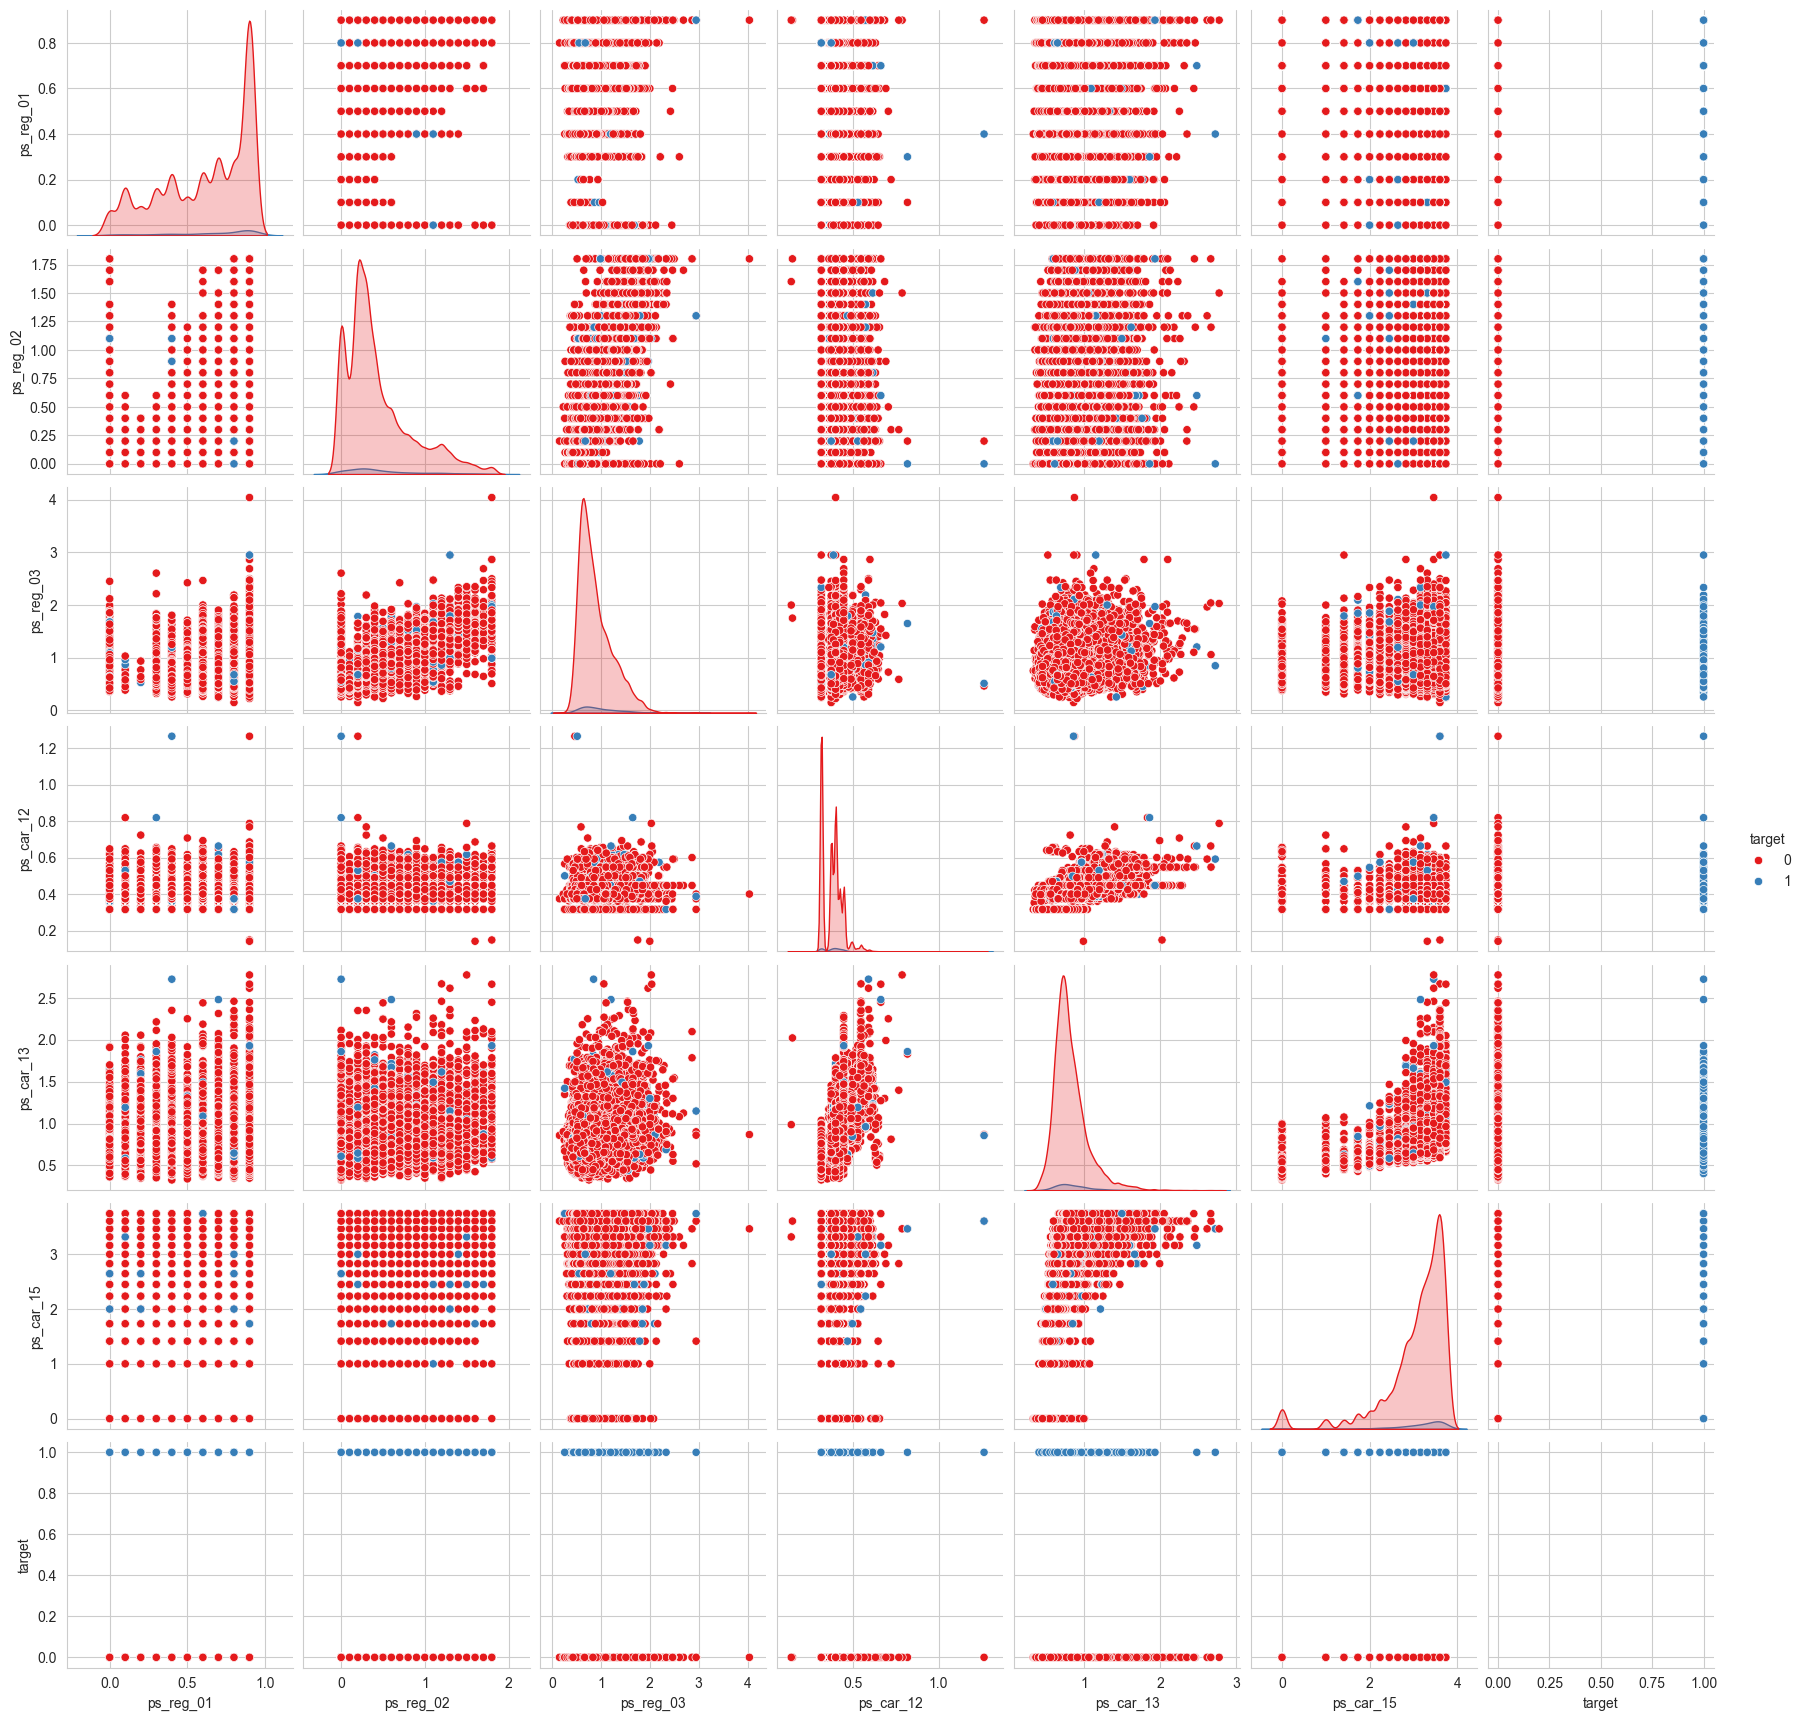

In [92]:
sample = trainset.sample(frac=0.05)
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample,  hue='target', palette = 'Set1', diag_kind='kde',vars=var)
plt.show()

C:\Users\hyeon\AppData\Local\Temp\ipykernel_23844\2731309335.py:23: UserWarning: Legend does not support handles for Axes instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend((p1, p2), ('Zero', 'One'))


<Figure size 640x480 with 0 Axes>

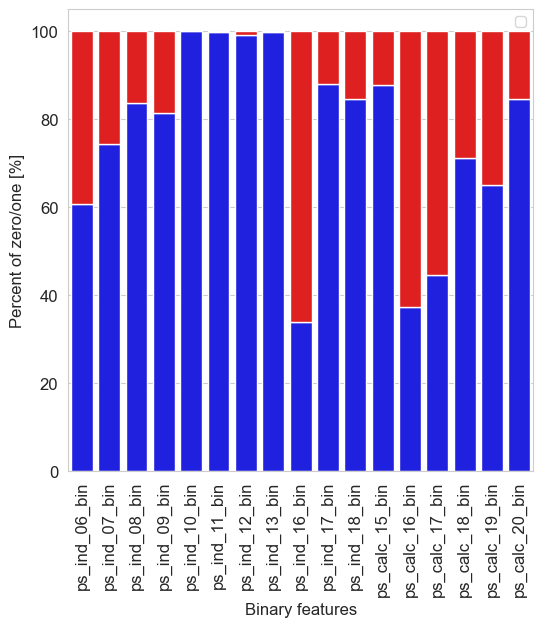

In [97]:
##### 5) binary features
v = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
trainset[v].describe()


# 파란색 : 0  , 빨간색 : 1
bin_col = [col for col in trainset.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((trainset[col]==0).sum()/trainset.shape[0]*100)
    one_list.append((trainset[col]==1).sum()/trainset.shape[0]*100)
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
# Bar plot
p1 = sns.barplot(ax=ax, x=bin_col, y=zero_list, color="blue")
p2 = sns.barplot(ax=ax, x=bin_col, y=one_list, bottom= zero_list, color="red")
plt.ylabel('Percent of zero/one [%]', fontsize=12)
plt.xlabel('Binary features', fontsize=12)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend((p1, p2), ('Zero', 'One'))
plt.show()

### 1의수가 매우적음 : ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin 
### 1의수가 상대적으로 큼 (60%이상): ps_ind_16_bin and ps_cals_16_bin 

<Figure size 640x480 with 0 Axes>

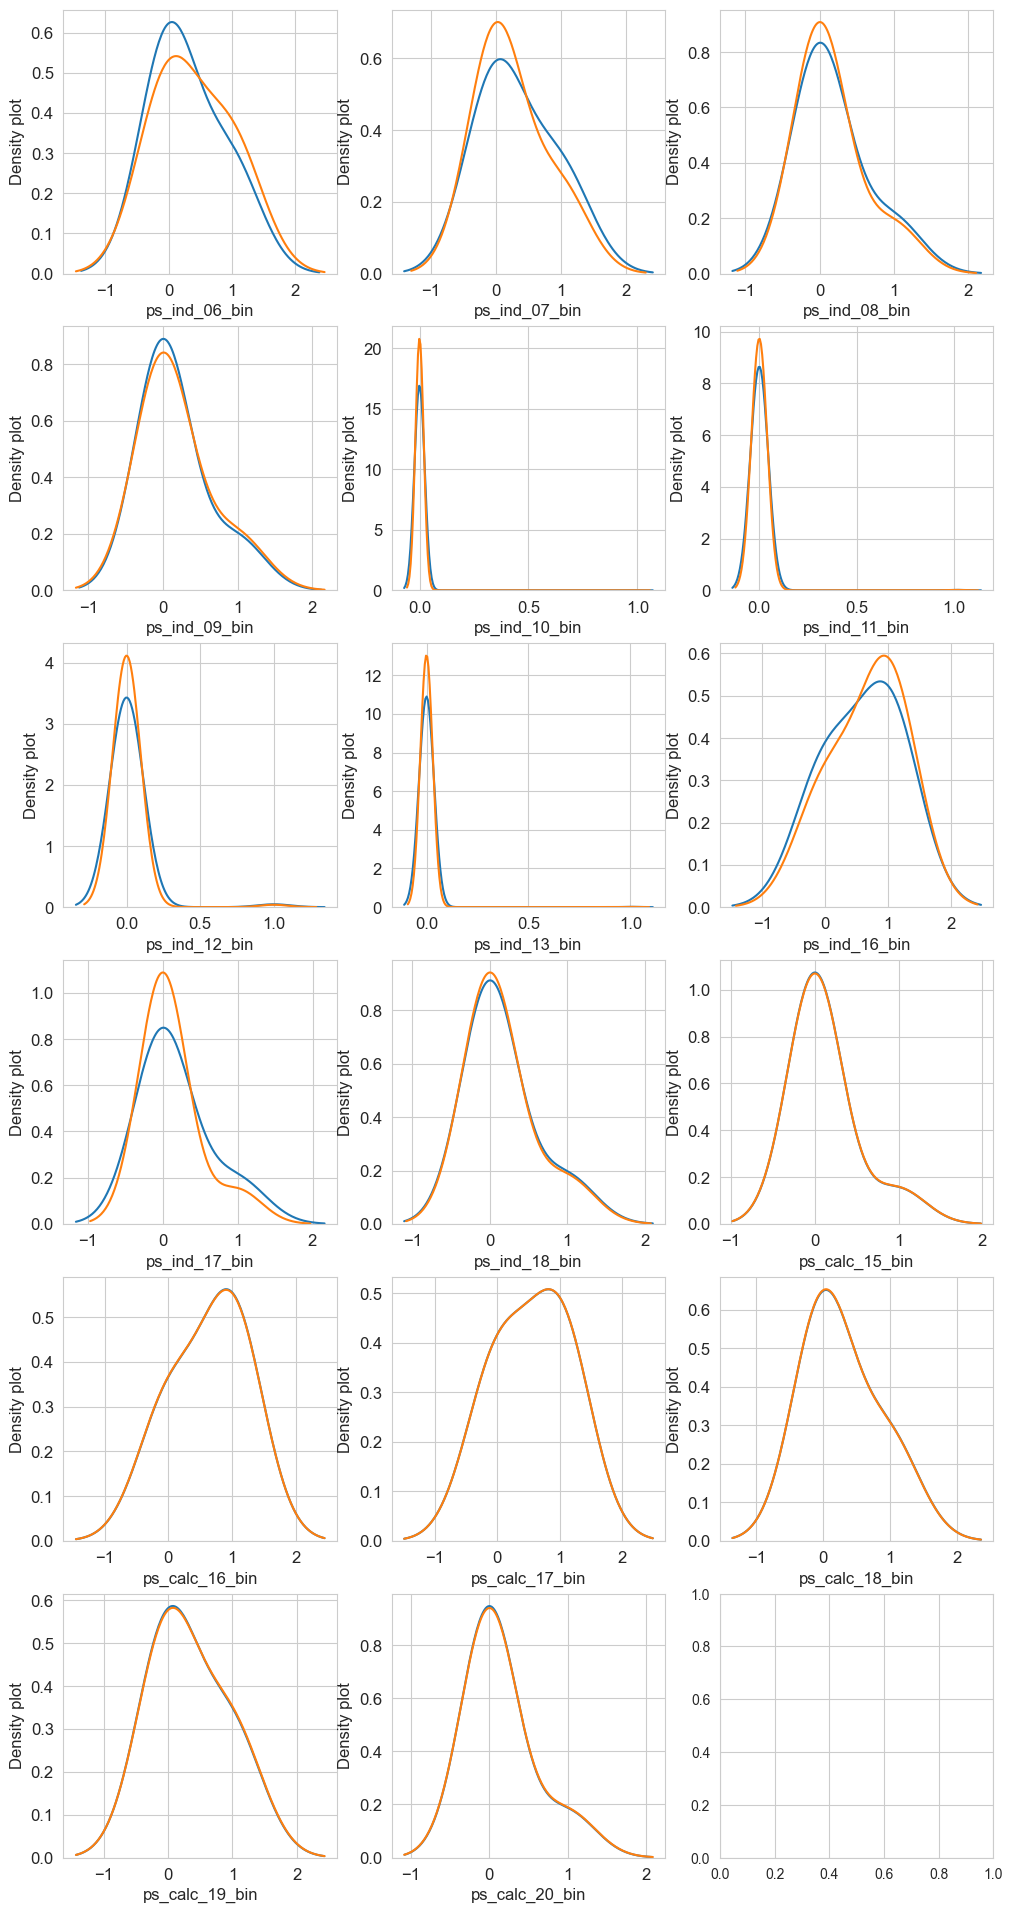

In [116]:
# 이진변수의 분포

var = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
var = [col for col in trainset.columns if '_bin' in col]
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(6,3,figsize=(12,24))

for feature in var:
    i += 1
    plt.subplot(6,3,i)
    sns.kdeplot(t1[feature],bw_method=1,label="target = 1")
    sns.kdeplot(t0[feature],bw_method=1,label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()


# ps_ind_06_bin, ps_ind_07_bin, ps_ind_16_bin, ps_ind_17_bin 의 경우 불균형한 분포
# ps_ind_08_bin 의 경우 작은 불균형한 분포 , 가장잘 균형이 맞는다. 


# 내생각 :  불균형한 분포 : ps_ind_06_bin,ps_ind_07_bin, ps_ind_16_bin,ps_ind_17_bin

ps_ind_02_cat    1.0
ps_ind_03        0.0
ps_ind_04_cat    0.0
ps_ind_05_cat    0.0
ps_car_01_cat    0.0
ps_car_02_cat    0.0
ps_car_03_cat    0.0
ps_car_04_cat    0.0
ps_car_05_cat    0.0
ps_car_06_cat    0.0
ps_car_07_cat    0.0
ps_car_08_cat    0.0
ps_car_09_cat    0.0
ps_car_10_cat    0.0
ps_car_11_cat    1.0
ps_car_11        0.0
dtype: float64


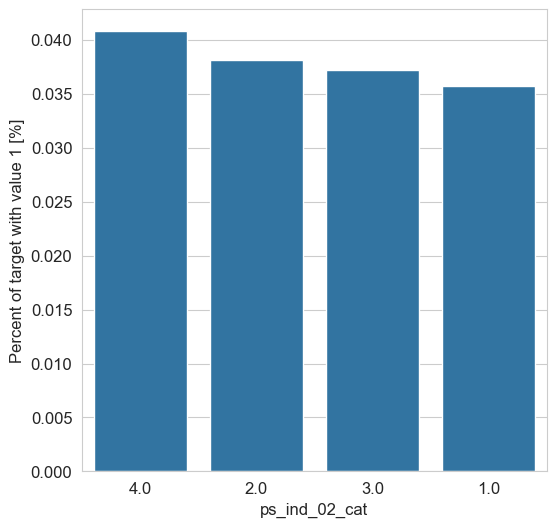

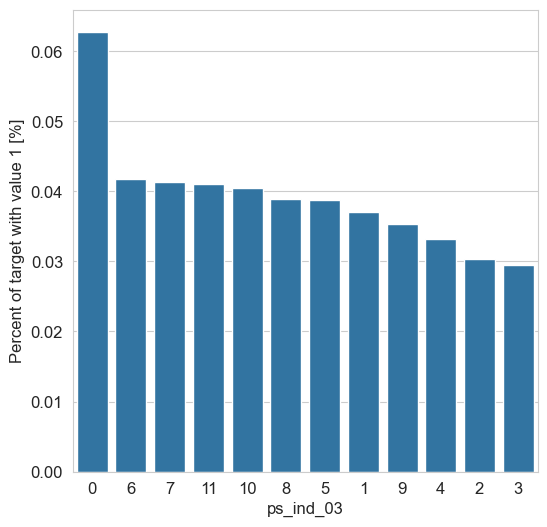

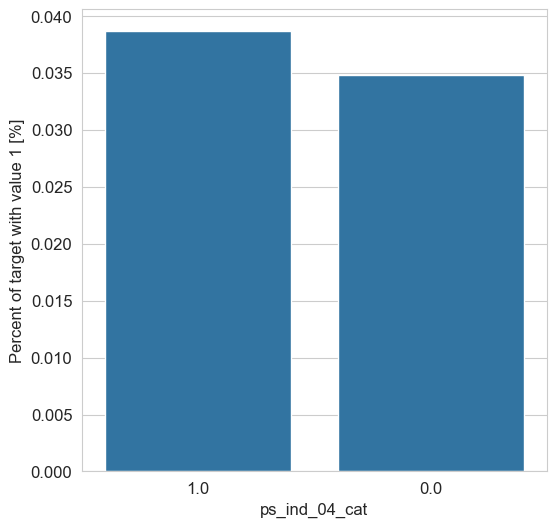

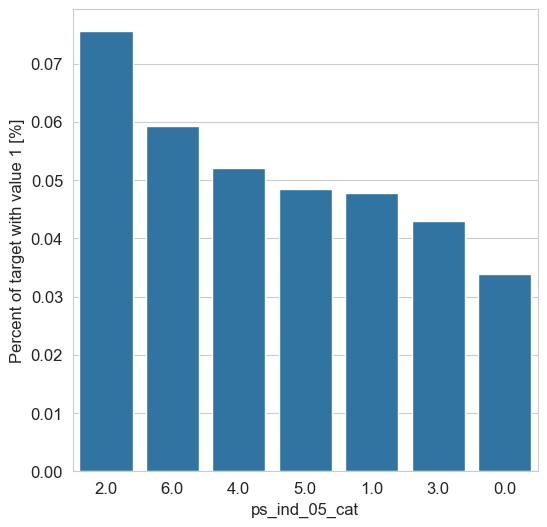

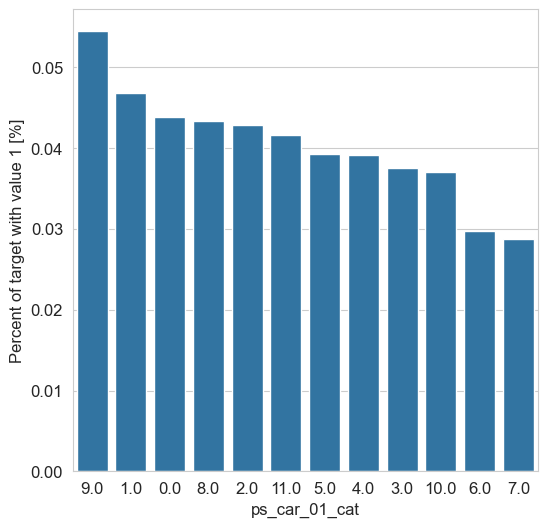

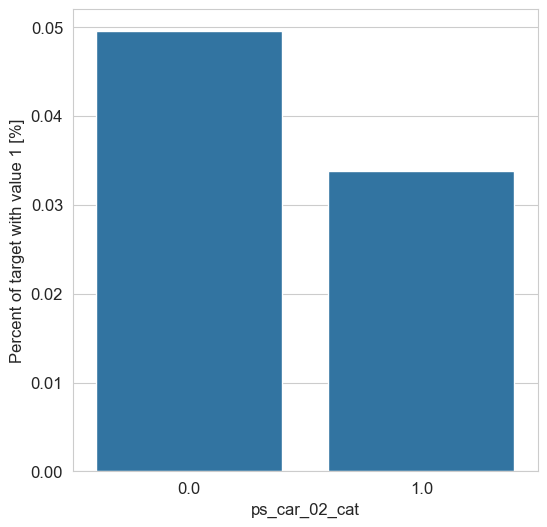

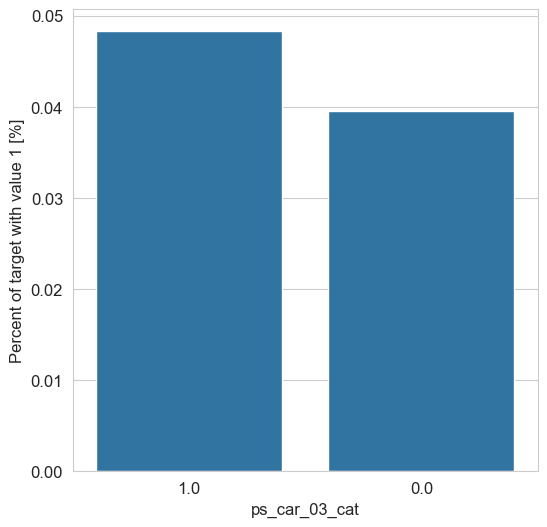

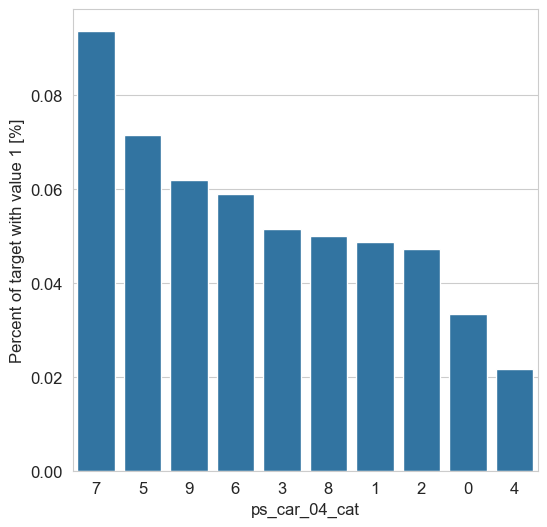

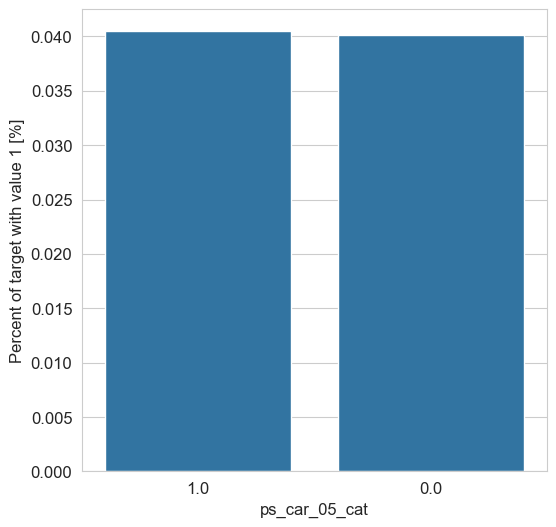

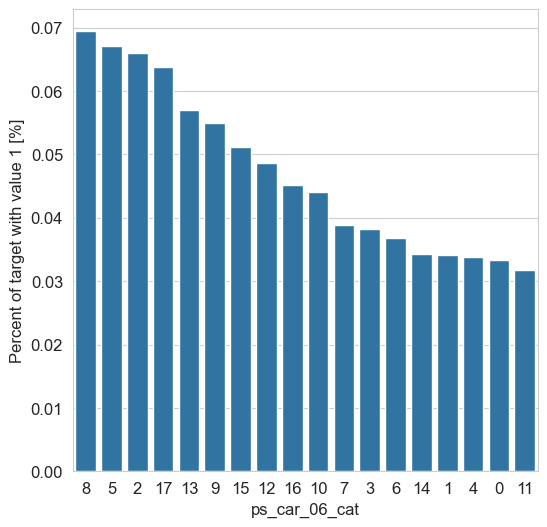

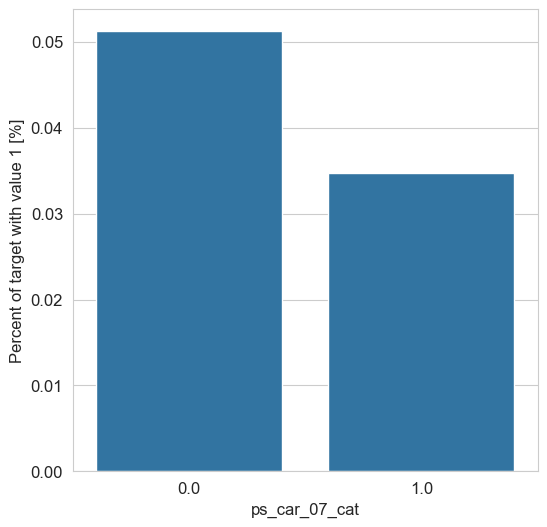

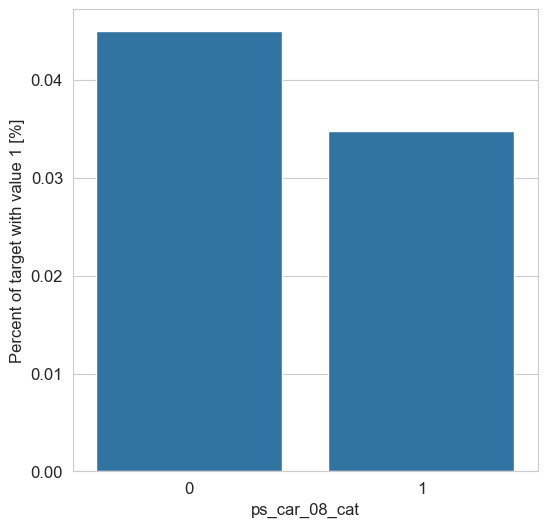

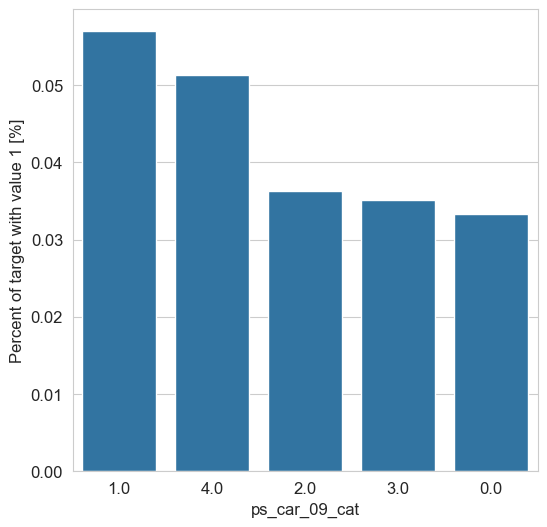

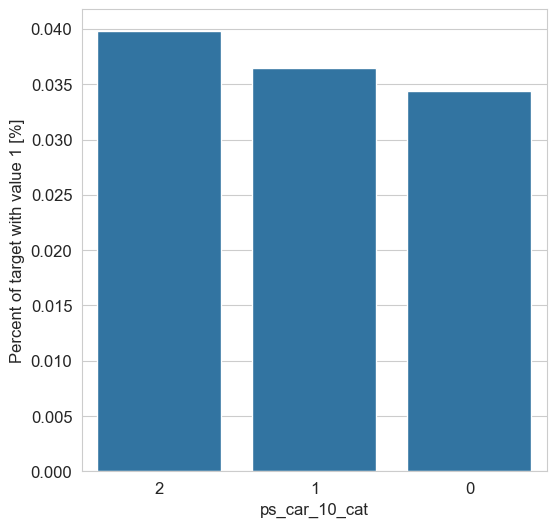

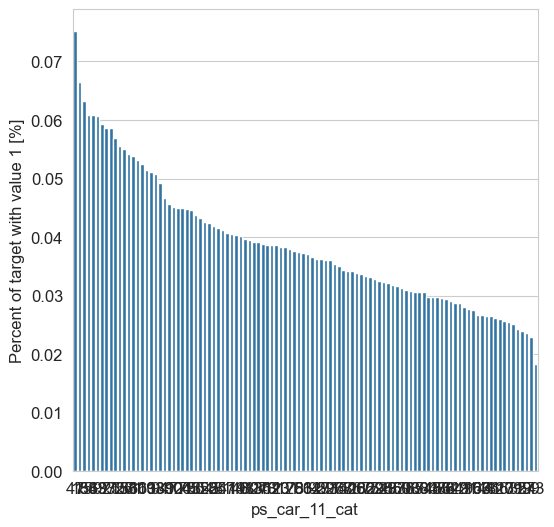

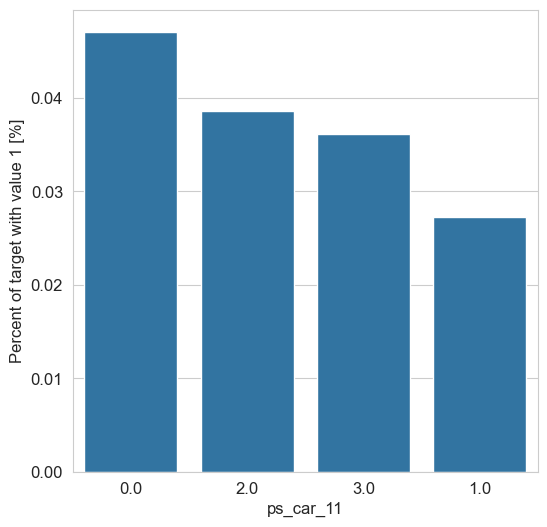

In [125]:
##### Categorical features

var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index
print(trainset[var].min())

for feature in var:
    fig, ax = plt.subplots(figsize=(6,6))
    # 타겟 1의 백분율 / category value 
    cat_perc = trainset[[feature, 'target']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar plot
    # target의 평균을 기준으로 내림차순
    sns.barplot(ax=ax,x=feature, y='target', data=cat_perc, order=cat_perc[feature])
    plt.ylabel('Percent of target with value 1 [%]', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

<Figure size 640x480 with 0 Axes>

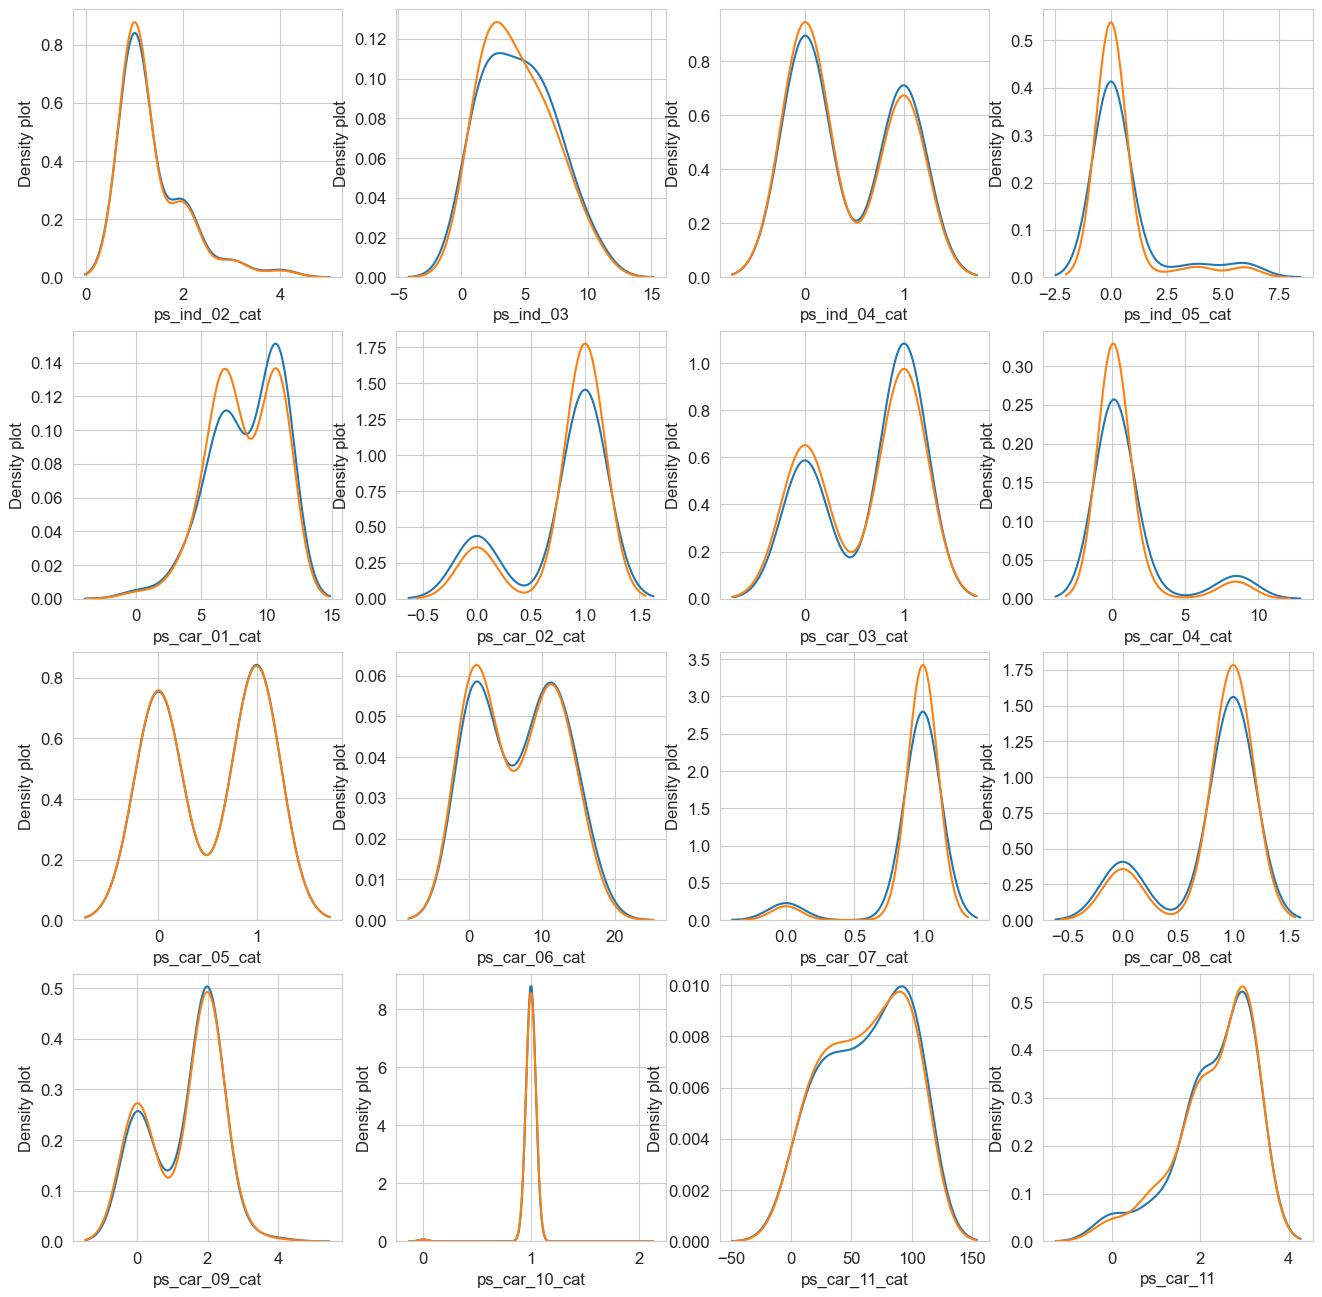

In [ ]:
##### Categorical features의 밀도플롯

var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(4,4,figsize=(16,16))

for feature in var:
    i += 1
    plt.subplot(4,4,i)
    sns.kdeplot(t1[feature], bw_method=0.5,label="target = 1")
    sns.kdeplot(t0[feature], bw_method=0.5,label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

## ps_car_03_cat, ps_car_05_cat 의 경우, 가장 다른 밀도플롯을 보여준다 ? 
## ps_ind_03, ps_ind_05_cat, ps_car_01_cat, ps_car_04_cat,ps_car_07_cat,ps_car_08_cat 아님?


## train 데이터와 test 데이터 간의 불균형 

<Figure size 640x480 with 0 Axes>

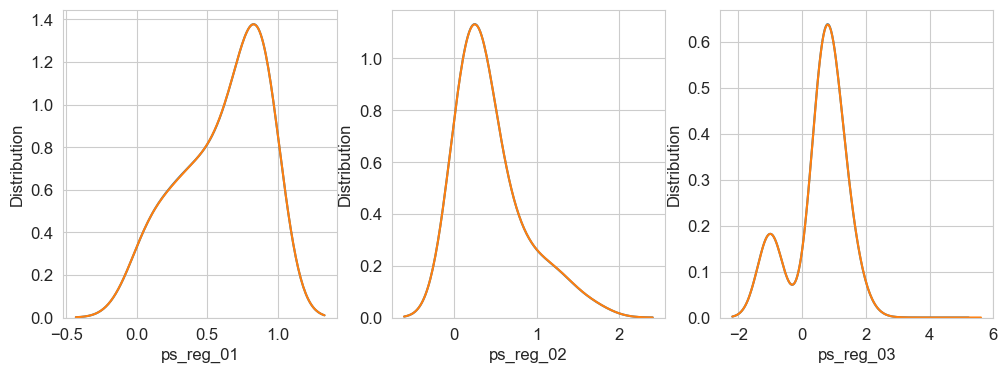

In [7]:


# reg의 경우  - 균형적

var = metadata[(metadata.category == 'registration') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(1,3,figsize=(12,4))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(1,3,i)
    sns.kdeplot(trainset[feature], bw_method=0.5, label="train")
    sns.kdeplot(testset[feature], bw_method=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

<Figure size 640x480 with 0 Axes>

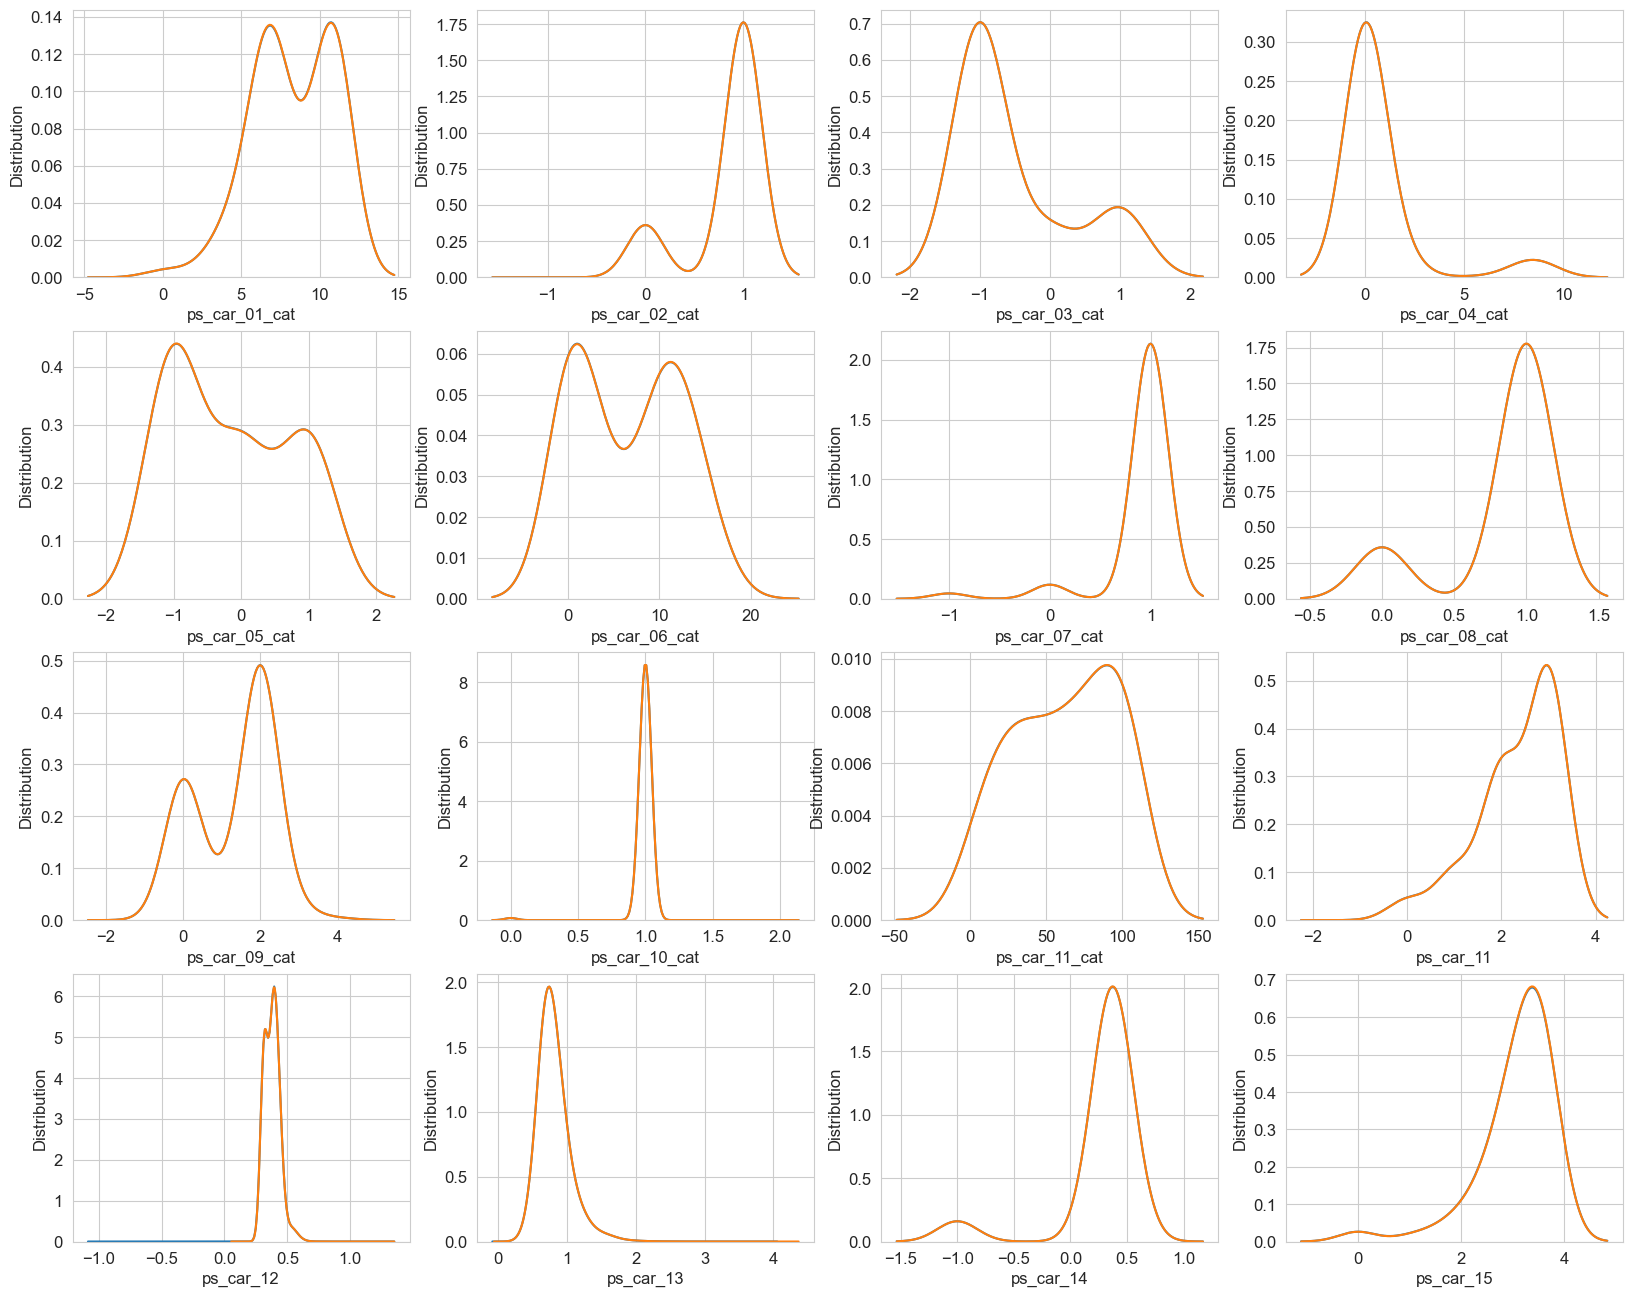

In [9]:
#car feature 의 경우  - 균형적

var = metadata[(metadata.category == 'car') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(4,4,figsize=(20,16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(4,4,i)
    sns.kdeplot(trainset[feature], bw_method=0.5, label="train")
    sns.kdeplot(testset[feature], bw_method=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

<Figure size 640x480 with 0 Axes>

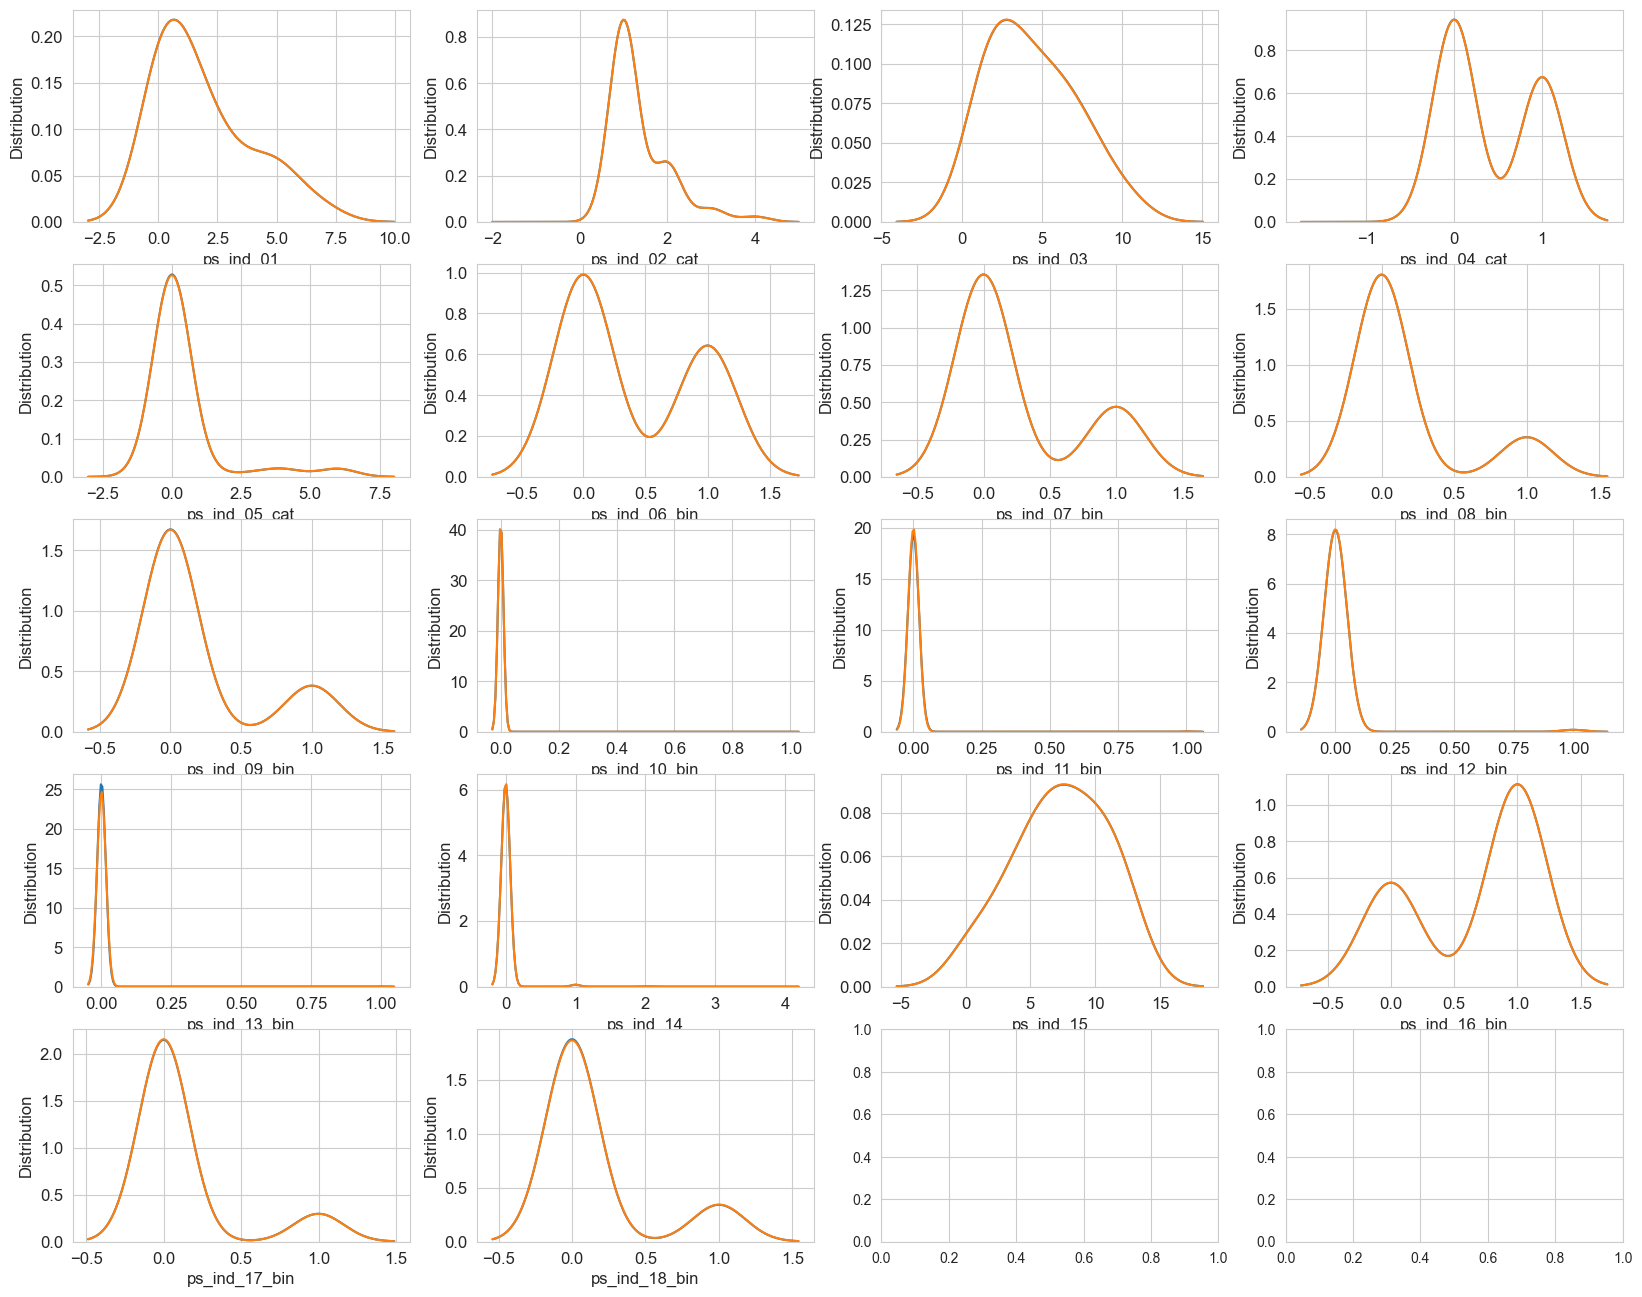

In [11]:
# individual - 균형적
var = metadata[(metadata.category == 'individual') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(5,4,figsize=(20,16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(5,4,i)
    sns.kdeplot(trainset[feature], bw_method=0.5, label="train")
    sns.kdeplot(testset[feature], bw_method=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

<Figure size 640x480 with 0 Axes>

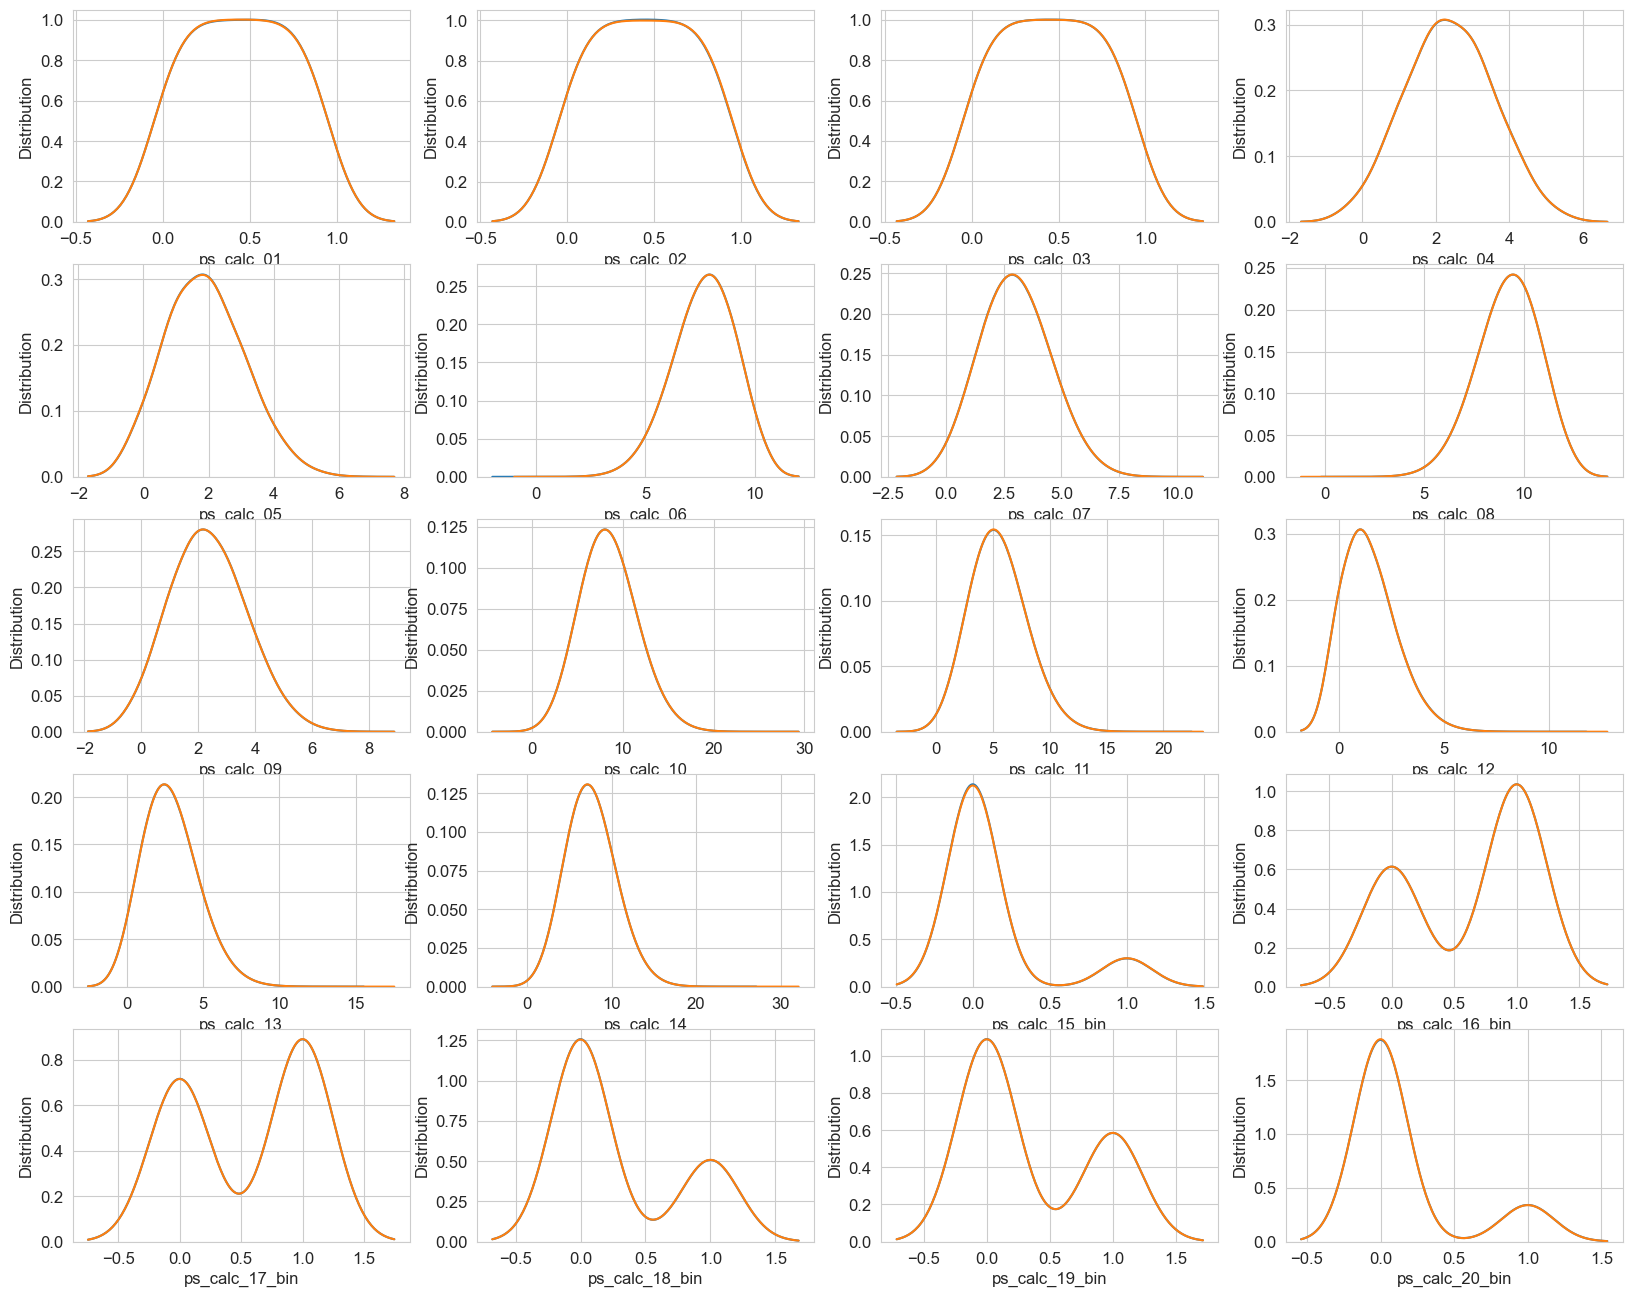

In [12]:
# calc features - 균형적

var = metadata[(metadata.category == 'calculated') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(5,4,figsize=(20,16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(5,4,i)
    sns.kdeplot(trainset[feature], bw_method=0.5, label="train")
    sns.kdeplot(testset[feature], bw_method=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

## 데이터 품질 확인

In [54]:
vars_with_missing = []

for feature in trainset.columns:
    missings = trainset[trainset[feature] == -1][feature].count()
    if missings > 0:
        vars_with_missing.append(feature)
        missings_perc = missings/trainset.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(feature, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values
In total, there are 13 variables with missing values


## 데이터 모델링 준비 

In [55]:
# calc 컬럼 삭제
col_to_drop = trainset.columns[trainset.columns.str.startswith('ps_calc_')]
trainset = trainset.drop(col_to_drop, axis=1)  
testset = testset.drop(col_to_drop, axis=1)  

In [56]:
# 결측값이 많은 변수들 삭제
# ps_car_03_cat ,ps_car_05_cat 

# inplace = true 의미 : 덮어쓰기 / https://www.dinolabs.ai/70

vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
trainset.drop(vars_to_drop, inplace=True, axis=1)
testset.drop(vars_to_drop, inplace=True, axis=1)
metadata.loc[(vars_to_drop),'keep'] = False 


In [57]:
# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [58]:
# target_encode 함수를 활용하여  ps_car_11_cat 을 인코딩된 변수로 대체
train_encoded, test_encoded = target_encode(trainset["ps_car_11_cat"], 
                             testset["ps_car_11_cat"], 
                             target=trainset.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    
trainset['ps_car_11_cat_te'] = train_encoded
trainset.drop('ps_car_11_cat', axis=1, inplace=True)
metadata.loc['ps_car_11_cat','keep'] = False  # Updating the metadata
testset['ps_car_11_cat_te'] = test_encoded
testset.drop('ps_car_11_cat', axis=1, inplace=True)

In [59]:
# target 변수값이 매우 불균형 하므로 , 타겟값 0을 과소 샘플링하거나, 타겟값 1을 과대샘플링해야함
# 현재 데이터셋이 매우 크므로 , 과소샘플링을 한다.


desired_apriori=0.10

# Get the indices per target value
idx_0 = trainset[trainset.target == 0].index
idx_1 = trainset[trainset.target == 1].index

# Get original number of records per target value
nb_0 = len(trainset.loc[idx_0])
nb_1 = len(trainset.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=314, n_samples=undersampled_nb_0)

# Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
trainset = trainset.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


In [60]:
# 결측값 -1을 Nan으로 대체

trainset = trainset.replace(-1, np.nan)
testset = testset.replace(-1, np.nan)

In [61]:
#  범주형 cat values 변수를 더미화 
# https://devuna.tistory.com/67
cat_features = [a for a in trainset.columns if a.endswith('cat')]

for column in cat_features:
    temp = pd.get_dummies(pd.Series(trainset[column]))
    trainset = pd.concat([trainset,temp],axis=1)
    trainset = trainset.drop([column],axis=1)
    
for column in cat_features:
    temp = pd.get_dummies(pd.Series(testset[column]))
    testset = pd.concat([testset,temp],axis=1)
    testset = testset.drop([column],axis=1)

In [63]:
# id, target 컬럼 삭제 
id_test = testset['id'].values
target_train = trainset['target'].values

trainset = trainset.drop(['target','id'], axis = 1)
testset = testset.drop(['id'], axis = 1)

KeyError: 'id'

In [65]:
# train, test set 조사
print("Train dataset (rows, cols):",trainset.values.shape, "\nTest dataset (rows, cols):",testset.values.shape)

Train dataset (rows, cols): (216940, 91) 
Test dataset (rows, cols): (892816, 91)


## 모델준비

In [67]:
# Ensemble 앙상블 모형 
# kfolds 방법으로 데이터 분할
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=314).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):

            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]


                print ("Base model %d: fit %s model | fold %d" % (i+1, str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)
                cross_score = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
                print("cross_score [roc-auc]: %.5f [gini]: %.5f" % (cross_score.mean(), 2*cross_score.mean()-1))
                y_pred = clf.predict_proba(X_holdout)[:,1]                

                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            S_test[:, i] = S_test_i.mean(axis=1)

        results = cross_val_score(self.stacker, S_train, y, cv=3, scoring='roc_auc')
        # Calculate gini factor as 2 * AUC - 1
        print("Stacker score [gini]: %.5f" % (2 * results.mean() - 1))

        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:,1]
        return res

In [69]:
# LightGBM params
# lgb_1
lgb_params1 = {}
lgb_params1['learning_rate'] = 0.02
lgb_params1['n_estimators'] = 650
lgb_params1['max_bin'] = 10
lgb_params1['subsample'] = 0.8
lgb_params1['subsample_freq'] = 10
lgb_params1['colsample_bytree'] = 0.8   
lgb_params1['min_child_samples'] = 500
lgb_params1['seed'] = 314
lgb_params1['num_threads'] = 4

# lgb2
lgb_params2 = {}
lgb_params2['n_estimators'] = 1090
lgb_params2['learning_rate'] = 0.02
lgb_params2['colsample_bytree'] = 0.3   
lgb_params2['subsample'] = 0.7
lgb_params2['subsample_freq'] = 2
lgb_params2['num_leaves'] = 16
lgb_params2['seed'] = 314
lgb_params2['num_threads'] = 4

# lgb3
lgb_params3 = {}
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 4
lgb_params3['learning_rate'] = 0.02
lgb_params3['seed'] = 314
lgb_params3['num_threads'] = 4

# XGBoost params
xgb_params = {}
xgb_params['objective'] = 'binary:logistic'
xgb_params['learning_rate'] = 0.04
xgb_params['n_estimators'] = 490
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9  
xgb_params['min_child_weight'] = 10
xgb_params['num_threads'] = 4

In [75]:
# Base models
lgb_model1 = LGBMClassifier(**lgb_params1,force_col_wise=True)

lgb_model2 = LGBMClassifier(**lgb_params2,force_col_wise=True)
       
lgb_model3 = LGBMClassifier(**lgb_params3,force_col_wise=True)

xgb_model = XGBClassifier(**xgb_params,force_col_wise=True)

# Stacking model
log_model = LogisticRegression()

In [76]:
stack = Ensemble(n_splits=3,
        stacker = log_model,
        base_models = (lgb_model1, lgb_model2, lgb_model3, xgb_model)) 

In [78]:
y_prediction = stack.fit_predict(trainset, target_train, testset)      

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\hyeon\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\hyeon\AppData\Local\Temp\ipykernel_27784\3929810551.py", line 1, in <module>
    y_prediction = stack.fit_predict(trainset, target_train, testset)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\hyeon\AppData\Local\Temp\ipykernel_27784\3237457160.py", line 10, in fit_predict
    X = np.array(X)
        ^^^^^^^^^^^
  File "c:\Users\hyeon\anaconda3\envs\kaggle\Lib\site-packages\pandas\core\generic.py", line 2149, in __array__
    values = self._values
             ^^^^^^^^^^^^
  File "c:\Users\hyeon\anaconda3\envs\kaggle\Lib\site-packages\pandas\core\frame.py", line 1116, in _values
    return ensure_wrapped_if_datetimelike(self.values)
                                          ^^^^^^^^^^^
  File "c:\Users\hyeon\anaconda3\env